In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import shap

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.utils import resample

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def standardize(non_binary_predictors, X_train, X_test=None):
    
    scaler = StandardScaler().fit(X_train[non_binary_predictors])
    
    # if x_test is passed in, or just x_train 
    if X_test is not None:
        X_train[non_binary_predictors] = scaler.transform(X_train[non_binary_predictors])
        X_test[non_binary_predictors] = scaler.transform(X_test[non_binary_predictors])
        return X_train, X_test
    else:
        X_train[non_binary_predictors] = scaler.transform(X_train[non_binary_predictors])
        return X_train  

def split_and_standardize(df, x_cols, y_col, non_binary_preds, interact_cols=None,
                         s=True):
    # separate into X and y
    X = df[x_cols]
    y = df[y_col]
    
    if interact_cols != None:
        for i,c in enumerate(interact_cols.keys()):
            X[c] = X[interact_cols[c][0]]*X[interact_cols[c][1]]
    
    # split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=109)
    
    # standardize
    if s==True:
        X_train_standardized, X_test_standardized = standardize(non_binary_preds, X_train,X_test)
        return X_train_standardized, y_train, X_test_standardized, y_test
    
    else:
        return X_train, y_train, X_test, y_test

In [14]:
df_train_low_pop = pd.read_csv('zip_train_yearly_lower_pop.csv').drop(columns=['Unnamed: 0'])
df_test_low_pop = pd.read_csv('zip_test_yearly_lower_pop.csv').drop(columns=['Unnamed: 0'])

df_train_high_pop = pd.read_csv('zip_train_yearly_higher_pop.csv').drop(columns=['Unnamed: 0'])
df_test_high_pop = pd.read_csv('zip_test_yearly_higher_pop.csv').drop(columns=['Unnamed: 0'])

df_train = pd.read_csv('zip_train_yearly.csv').drop(columns=['Unnamed: 0'])
df_test = pd.read_csv('zip_test_yearly.csv').drop(columns=['Unnamed: 0'])


In [5]:
# all categories of cvd: chf,  ischemic stroke,heart attack, heart disease
# source: https://www.heart.org/en/health-topics/consumer-healthcare/what-is-cardiovascular-disease
x_col = ['sex','mean_age','population', #'popdensity',
       'poverty',  'medianhousevalue', 
       'medhouseholdincome', 'pct_owner_occ',  'education',
       'smoke_rate', 'mean_bmi', 'race_1', 'race_2','race_3', 'race_4', 'race_5', 'race_6',
        'ICU_DAY', 'CCI_DAY', 'LOS',
       'Parkinson_pdx2dx_25', 'Alzheimer_pdx2dx_25', 'Dementia_pdx2dx_25',
       'COPD_pdx2dx_25', 'DM_pdx2dx_25',
       'Stroke_pdx2dx_25', 'CVD_pdx2dx_25', 'neo_140_149',
       'neo_150_159', 'neo_160_165', 'neo_170_176', 'neo_179_189',
       'neo_190_199', 'neo_200_209', 'neo_210_229', 'neo_230_234',
       'neo_235_238', 'neo_239', #'pm25','ozone','no2','tmmx','rmax']
        'pm25_summer_4y_avg', 'pm25_winter_4y_avg', # 'summer_pm25_above_12','winter_pm25_above_12',#
       'pm25_fall_4y_avg', 'pm25_spring_4y_avg', 'ozone_summer_4y_avg',
       'ozone_winter_4y_avg', 'ozone_fall_4y_avg', 'ozone_spring_4y_avg',
       'no2_summer_4y_avg', 'no2_winter_4y_avg', 'no2_fall_4y_avg',
       'no2_spring_4y_avg', 'summer_tmmx_4y_avg', 'summer_rmax_4y_avg',
       'winter_tmmx_4y_avg', 'winter_rmax_4y_avg']

y_col = 'deaths_next_year'
non_binary_preds = x_col

In [6]:
X_train_standardized, y_train, X_test_standardized, y_test = split_and_standardize(df_train,x_col, y_col, non_binary_preds)
# split into train and test and not standardize - not needed for tree models
X_train, y_train, X_test, y_test = split_and_standardize(df_train, x_col,y_col, non_binary_preds, s=False)

In [ ]:
X_train_standardized_lower, y_train_lower, X_test_standardized_lower, y_test_lower = split_and_standardize(df_train_low_pop, 
                                                                                                           x_col, y_col, non_binary_preds)

# split into train and test and standardize
X_train_standardized_higher, y_train_higher, X_test_standardized_higher, y_test_higher = split_and_standardize(df_train_high_pop, x_col, y_col, non_binary_preds)


In [15]:
# split into train and test and standardize
X_train_standardized_lower, y_train_lower, X_test_standardized_lower, y_test_lower = split_and_standardize(df_train_low_pop, 
                                                                                                           x_col, y_col, non_binary_preds)
# # split into train and test and not standardize - not needed for tree models
# X_train_lower, y_train_lower, X_test_lower, y_test_lower = split_and_standardize(df_train_low_pop, x_col,y_col, non_binary_preds, s=False)

# # split into train and test and standardize
X_train_standardized_higher, y_train_higher, X_test_standardized_higher, y_test_higher = split_and_standardize(df_train_high_pop, x_col, y_col, non_binary_preds)

# # split into train and test and not standardize - not needed for tree models
# X_train_higher, y_train_higher, X_test_higher, y_test_higher = split_and_standardize(df_train_high_pop, x_col,y_col, non_binary_preds, s=False)

### Gradient Boosting (Regressor)

https://blog.paperspace.com/implementing-gradient-boosting-regression-python/

https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html

Lower Population

In [8]:
# X_train_sub, y_train_sub, X_test_sub, y_test_sub
gbr_model = GradientBoostingRegressor(learning_rate=0.1,
                                      n_estimators=350,
                                      min_samples_split=2,
                                      min_samples_leaf=1,
                                      max_depth=7,
                                      max_features='sqrt')

gbr_model.fit(X_train_standardized, y_train)
print(gbr_model.score(X_train_standardized, y_train))
print(gbr_model.score(X_test_standardized, y_test))

0.9843789585294316
0.9558729708074317


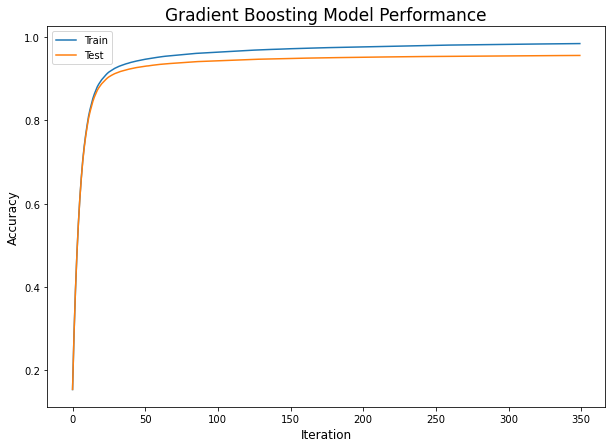

In [9]:
gbr_train_score = np.zeros((350,), dtype=np.float64)
for i, y_pred in enumerate(gbr_model.staged_predict(X_train_standardized)):
    gbr_train_score[i] = r2_score(y_train, y_pred)
    
gbr_test_score = np.zeros((350,), dtype=np.float64)
for i, y_pred in enumerate(gbr_model.staged_predict(X_test_standardized)):
    gbr_test_score[i] = r2_score(y_test, y_pred)

f, ax = plt.subplots(1, figsize=(10,7))
ax.plot(gbr_train_score,label='Train')
ax.plot(gbr_test_score,label='Test')
ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title("Gradient Boosting Model Performance", fontsize=17)
plt.legend()
plt.show()

In [11]:
# gbr_train_pred_sub = gbr_model.predict(X_train_sub)
# gbr_test_pred_sub = gbr_model.predict(X_test_sub)
gbr_train_pred = gbr_model.predict(X_train_standardized)
gbr_test_pred = gbr_model.predict(X_test_standardized)

print(mean_squared_error(y_test, gbr_test_pred))
print(mean_squared_error(y_test, gbr_test_pred, squared=False))

352.88684825237954
18.785282756785417


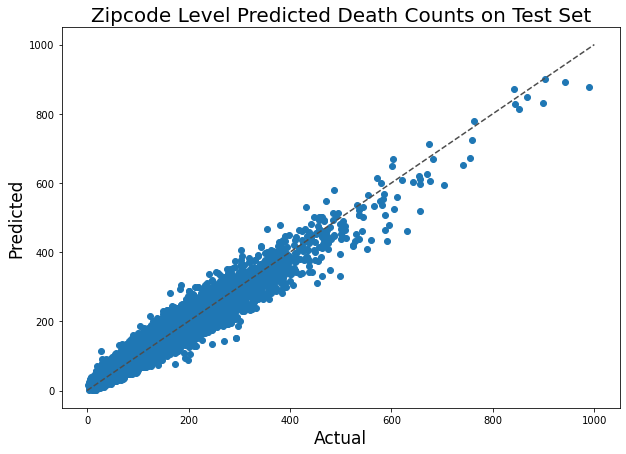

In [13]:
# note death is shifted, so must plot actual - year prior
plt.figure(figsize=(10,7))
plt.scatter(y_test,gbr_test_pred) 
plt.plot([0, 1000], [0, 1000], ls="--", c=".3")
plt.title("Zipcode Level Predicted Death Counts on Test Set", fontsize=20)
plt.ylabel("Predicted", fontsize=17)
plt.xlabel("Actual", fontsize=17)
plt.show()

In [16]:
gbr_train_pred_lower = gbr_model.predict(X_train_standardized_lower)
gbr_test_pred_lower = gbr_model.predict(X_test_standardized_lower)


Shap - all zips within 2015

In [17]:
explainer_test_lower = shap.TreeExplainer(gbr_model)
shap_values_test_lower = explainer_test_lower.shap_values(X_test_standardized_lower)
np.abs(shap_values_test_lower.sum(1) + explainer_test_lower.expected_value - gbr_test_pred_lower).max()

2.2737367544323206e-12

In [1]:
f,ax = plt.subplots(1,1, figsize=(10,10))
shap.summary_plot(shap_values_test_lower,X_test_standardized_lower,show=False)
plt.title("SHAP Values for Select Zipcodes", fontsize=20)
plt.show()

- having higher values of summer pm concentration tends to decrease death counts by about 2.5
- having higher summer temperature (hotter) tends to decrease death counts by 10
- having warmer winter temperature tends to increase death counts by 15
- value of 0 means it have no contribution to death count

In [2]:
f,axes=plt.subplots(1,1,figsize=(12,8))
shap.dependence_plot("medianhousevalue", shap_values_test_lower, X_test_standardized_lower, dot_size=15,show=False,ax=axes)
# plt.axhline(y=0, color='black', linestyle='--',alpha=0.7,label='SHAP=0')
plt.ylabel('SHAP Value for Median House Value',fontsize=15)
plt.xlabel('Median House Value',fontsize=15)
plt.title('Median House Value Dependence Plot',fontsize=20)
# plt.legend()
plt.show()

- looks like extreme winter temps contribute more to annual deaths (i.e. very cold, or very warm for winter)

In [3]:
f,axes=plt.subplots(1,1,figsize=(12,8))
shap.dependence_plot("Stroke_pdx2dx_25", shap_values_test_lower, X_test_standardized_lower, dot_size=15,show=False,ax=axes)
plt.axhline(y=0, color='black', linestyle='--',alpha=0.7,label='SHAP=0')
plt.ylabel('SHAP Value for Stroke',fontsize=15)
plt.xlabel('Stroke (4 Year Ave)',fontsize=15)
plt.title('Stroke Dependence Plot',fontsize=20)
plt.legend()
plt.show()

In [4]:
f,axes=plt.subplots(1,1,figsize=(12,8))
shap.dependence_plot("CVD_pdx2dx_25", shap_values_test_lower, X_test_standardized_lower, dot_size=15,show=False,ax=axes)
plt.axhline(y=0, color='black', linestyle='--',alpha=0.7,label='SHAP=0')
plt.ylabel('SHAP Value for CVD',fontsize=15)
plt.xlabel('CVD',fontsize=15)
plt.title('CVD Dependence Plot',fontsize=20)
plt.legend()
plt.show()

In [5]:
f,axes=plt.subplots(1,1,figsize=(15,10))
shap.dependence_plot("mean_age", shap_values_test_lower, X_test_standardized_lower, dot_size=15,show=False,ax=axes)
plt.axhline(y=0, color='black', linestyle='--',alpha=0.7,label='SHAP=0')
plt.ylabel('SHAP Value for Average Age',fontsize=15)
plt.xlabel('Age',fontsize=15)
plt.title('Age Dependence Plot',fontsize=20)
plt.legend()
plt.show()

In [7]:
f,axes=plt.subplots(1,1,figsize=(15,10))
shap.dependence_plot("education", shap_values_test_lower, X_test_standardized_lower, dot_size=15,show=False,ax=axes)
plt.axhline(y=0, color='black', linestyle='--',alpha=0.7,label='SHAP=0')
plt.ylabel('SHAP Value for % Incomplete HS Education',fontsize=15)
plt.xlabel('% Incomplete HS Education',fontsize=15)
plt.title('%Incomplete HS Education Dependence Plot',fontsize=20)
plt.legend()
plt.show()

In [8]:
f,axes=plt.subplots(1,1,figsize=(15,10))
shap.dependence_plot("population", shap_values_test_lower, X_test_standardized_lower, dot_size=10,show=False,ax=axes)
plt.axhline(y=0, color='black', linestyle='--',alpha=0.7,label='SHAP=0')
plt.ylabel('SHAP Value for Population',fontsize=15)
plt.xlabel('Population',fontsize=15)
plt.title('Population Dependence Plot',fontsize=20)
plt.legend()
plt.show() 

In [9]:
f,axes=plt.subplots(1,1,figsize=(15,10))
shap.dependence_plot("race_2", shap_values_test_lower, X_test_standardized_lower, dot_size=10,show=False,ax=axes)
plt.axhline(y=0, color='black', linestyle='--',alpha=0.7,label='SHAP=0')
plt.ylabel('SHAP Value for % Black',fontsize=15)
plt.xlabel('% Black',fontsize=15)
plt.title('% BlackDependence Plot',fontsize=20)
plt.legend()
plt.show() 

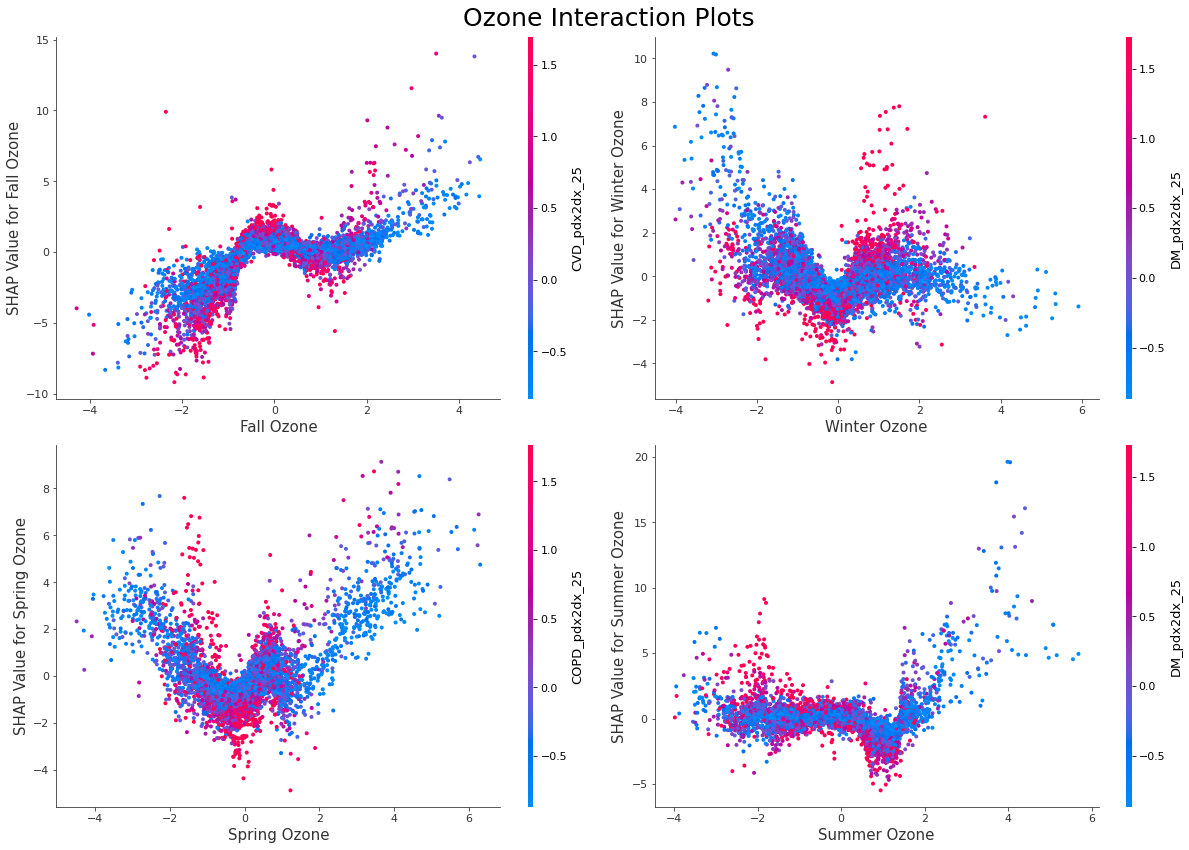

In [28]:
ys = ['ozone_fall_4y_avg','ozone_winter_4y_avg','ozone_spring_4y_avg','ozone_summer_4y_avg']
x_labs = ['Fall Ozone','Winter Ozone','Spring Ozone','Summer Ozone']
y_labs = ['SHAP Value for Fall Ozone','SHAP Value for Winter Ozone',
          'SHAP Value for Spring Ozone','SHAP Value for Summer Ozone']

f, axes = plt.subplots(2,2, figsize=(17, 12))
axes = axes.ravel()

# make plots colored by each of the top three possible interacting features
for j in range(4):
    inds = shap.approximate_interactions(ys[j], shap_values_test_lower, X_test_standardized_lower)
    shap.dependence_plot(ys[j],shap_values_test_lower, X_test_standardized_lower, 
                        ax=axes[j], show=False)  
    axes[j].set_xlabel(x_labs[j], fontsize=15)
    axes[j].set_ylabel(y_labs[j], fontsize=15)
#     axes[j].set_ylim(-10,8)
#     if j == 0 or j == 2:
#         axes[j].set_xlim(15,60)
#     if j == 1 or j == 3:
#         axes[j].set_xlim(15,80)
#     if j == 0 or j == 1:
#         axes[j].set_ylim(-10,20)
#     if j == 2 or j == 3:
#         axes[j].set_ylim(-10,40)
plt.suptitle('Ozone Interaction Plots', fontsize=25)
plt.tight_layout()
plt.show()

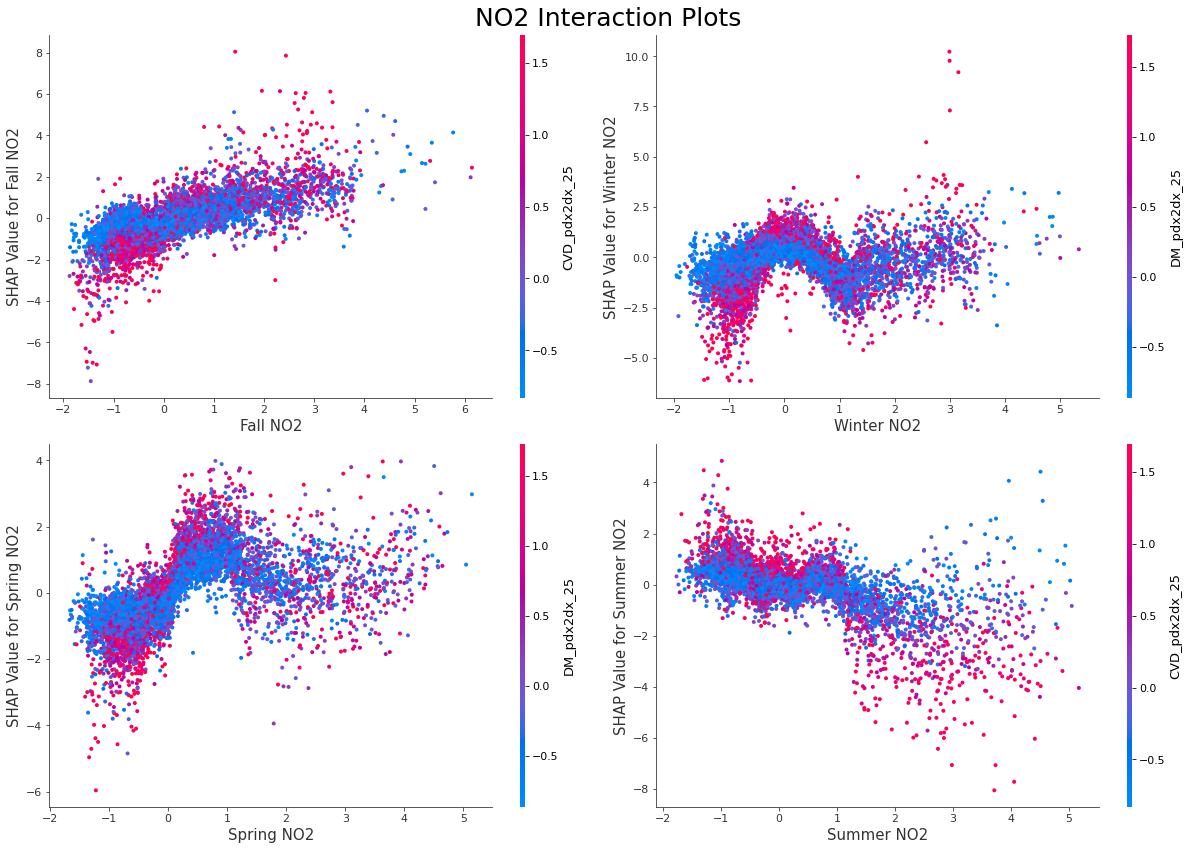

In [29]:
ys = ['no2_fall_4y_avg','no2_winter_4y_avg','no2_spring_4y_avg','no2_summer_4y_avg']
x_labs = ['Fall NO2','Winter NO2','Spring NO2','Summer NO2']
y_labs = ['SHAP Value for Fall NO2','SHAP Value for Winter NO2',
          'SHAP Value for Spring NO2','SHAP Value for Summer NO2']

f, axes = plt.subplots(2,2, figsize=(17, 12))
axes = axes.ravel()

# make plots colored by each of the top three possible interacting features
for j in range(4):
    inds = shap.approximate_interactions(ys[j], shap_values_test_lower, X_test_standardized_lower)
    shap.dependence_plot(ys[j], shap_values_test_lower, X_test_standardized_lower, 
                        ax=axes[j], show=False)  
    axes[j].set_xlabel(x_labs[j], fontsize=15)
    axes[j].set_ylabel(y_labs[j], fontsize=15)
#     axes[j].set_xlim(0,50)
#     axes[j].set_ylim(-8,8)
plt.suptitle('NO2 Interaction Plots', fontsize=25)
plt.tight_layout()
plt.show()

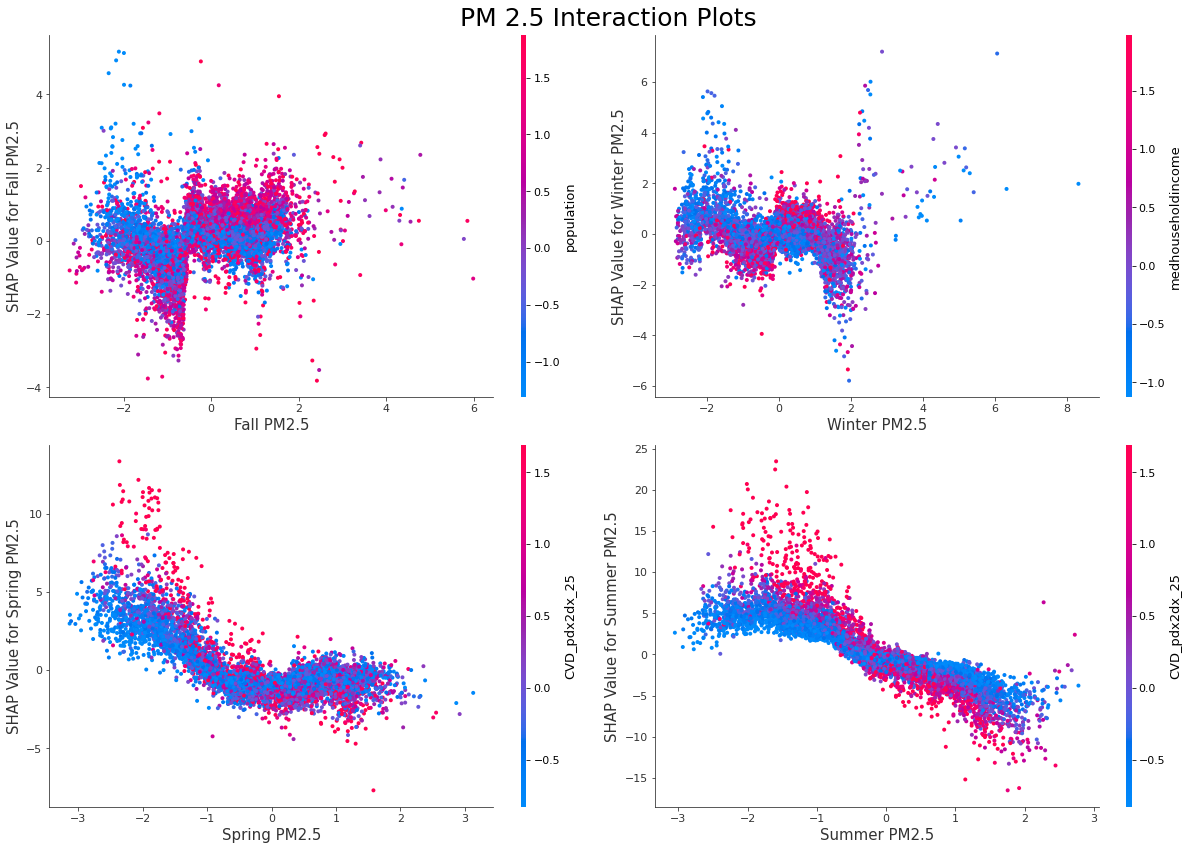

In [30]:
ys = ['pm25_fall_4y_avg','pm25_winter_4y_avg','pm25_spring_4y_avg','pm25_summer_4y_avg']
x_labs = ['Fall PM2.5','Winter PM2.5','Spring PM2.5','Summer PM2.5']
y_labs = ['SHAP Value for Fall PM2.5','SHAP Value for Winter PM2.5',
          'SHAP Value for Spring PM2.5','SHAP Value for Summer PM2.5']

f, axes = plt.subplots(2,2, figsize=(17, 12))
axes = axes.ravel()

# make plots colored by each of the top three possible interacting features
for j in range(4):
    inds = shap.approximate_interactions(ys[j], shap_values_test_lower,X_test_standardized_lower)
    shap.dependence_plot(ys[j], shap_values_test_lower, X_test_standardized_lower, 
                        ax=axes[j], show=False)  
    axes[j].set_xlabel(x_labs[j], fontsize=15)
    axes[j].set_ylabel(y_labs[j], fontsize=15)
#     if j == 0 or j == 2:
#         axes[j].set_xlim(0,18)
#     if j == 1 or j == 3:
#         axes[j].set_xlim(0,30)
#     if j == 0 or j == 1:
#         axes[j].set_ylim(-8,10)
#     if j == 2 or j == 3:
#         axes[j].set_ylim(-15,18)
plt.suptitle('PM 2.5 Interaction Plots', fontsize=25)
plt.tight_layout()
plt.show()

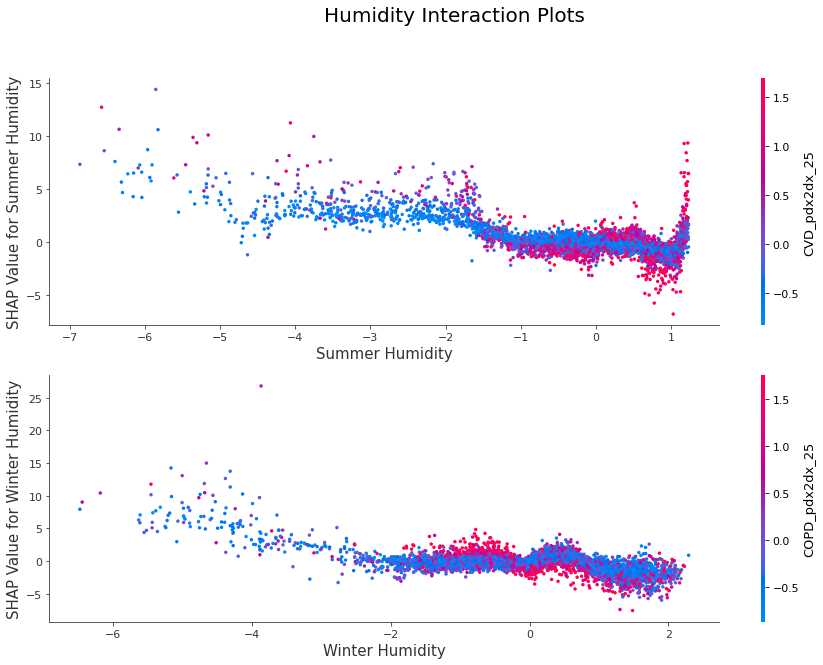

In [31]:
ys = ['summer_rmax_4y_avg','winter_rmax_4y_avg']
x_labs = ['Summer Humidity','Winter Humidity']
y_labs = ['SHAP Value for Summer Humidity','SHAP Value for Winter Humidity']

f, axes = plt.subplots(2,1, figsize=(15, 10))
axes = axes.ravel()

# make plots colored by each of the top three possible interacting features
for j in range(2):
    inds = shap.approximate_interactions(ys[j], shap_values_test_lower, X_test_standardized_lower)
    shap.dependence_plot(ys[j], shap_values_test_lower,X_test_standardized_lower,  dot_size=12,
                        ax=axes[j], show=False)  
    axes[j].set_xlabel(x_labs[j], fontsize=15)
    axes[j].set_ylabel(y_labs[j], fontsize=15)
#     axes[j].set_xlim(20,100)
#     axes[j].set_ylim(-10,15)
plt.suptitle('Humidity Interaction Plots', fontsize=20)
# plt.tight_layout()
plt.show()

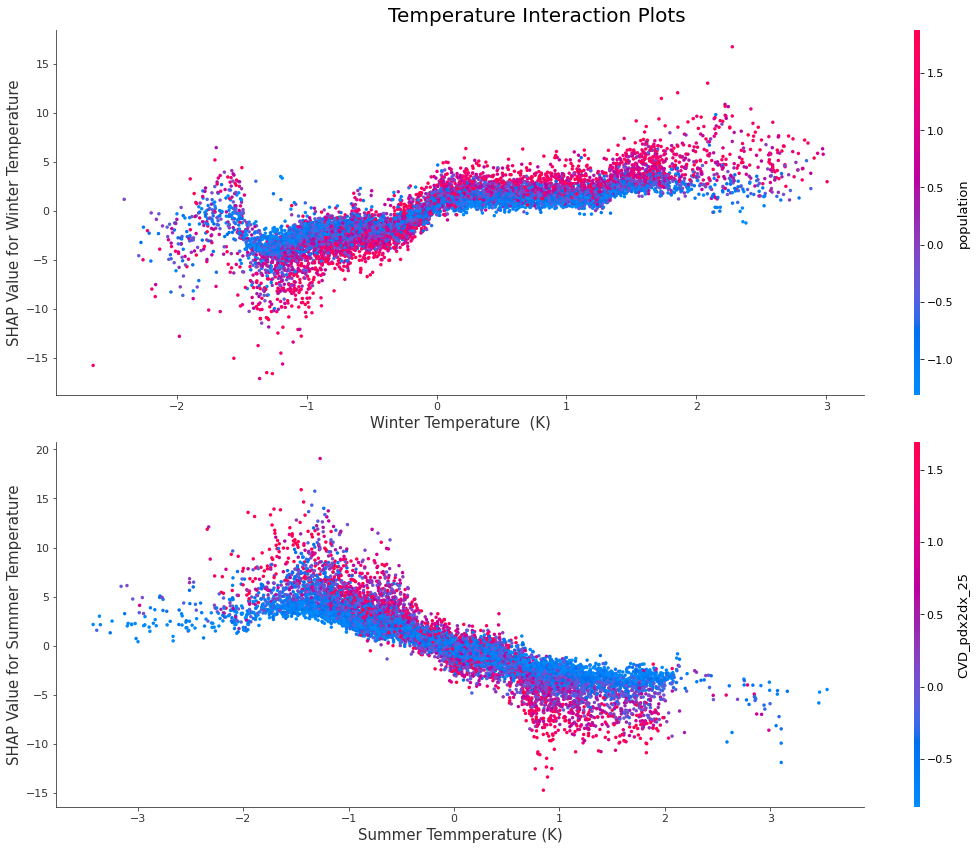

In [32]:
ys = ['winter_tmmx_4y_avg','summer_tmmx_4y_avg']
x_labs = ['Winter Temperature  (K)','Summer Temmperature (K)']
y_labs = ['SHAP Value for Winter Temperature','SHAP Value for Summer Temperature']
titles=['Winter Temperature  (K)','summerTemmperature (K)']

f, axes = plt.subplots(2,1, figsize=(15, 12))
axes = axes.ravel()

# make plots colored by each of the top three possible interacting features
for j in range(2):
    inds = shap.approximate_interactions(ys[j], shap_values_test_lower,X_test_standardized_lower)
    shap.dependence_plot(ys[j], shap_values_test_lower,X_test_standardized_lower, dot_size=12,
                        ax=axes[j], show=False)  
#     axes[j].set_xlim(260,315)
#     axes[j].set_ylim(-20,25)
    axes[j].set_xlabel(x_labs[j], fontsize=15)
    axes[j].set_ylabel(y_labs[j], fontsize=15)
plt.suptitle('Temperature Interaction Plots', fontsize=20)
plt.tight_layout()
plt.show()

- winter temp 26-53 - something odd is happening here - only place contributing to reducing deaths
    -  the interaction of no2 in this area (red dots above and below show there is probably another feature correlated that is affecting this
- summer: extreme temp over 80 - contributing to reducing annual deaths

- summer pm below 9 contributes to death counts
- summer pm above 9 reduces predicted death counts

- my guess of this correlation - maybe an increase in summer pm2.5 concentrations may lead to more hospitalizations - if caught and helped, then less deaths?
- so not causally linked here at all, but because air pollution not main indicator of death less of an impact of death, doesnt mean it doesnt have an impact on underlying health issues within the population

- interesting a focus of zips with higher winter humidity and lower number deaths
- interesting so see that a large number of zips have higher summer humidity and lower number of deaths, and notice that there's a relatively upward trend/posative correlation between higher concentrations of summer pm2.5 and summer humidity (i.e. higher summer air pollution softly correlates with higher summer humidity)

- higher summer pm corresponding to summer temp around 80 - 98
- higher summer pm also corresponding to high summer humidity

In [193]:
# plt.hist(high_pm.ICU_DAY,bins=50)
# plt.show()
# what would have a low association with death and positive association with pm2.5? lower LOS?
# race 2 - communities with more black % also happen to be areas with med-higher pm2.5, similar to race_3 (other race?)
# high race 2, high race 4, high popdensity, high mean age
# parkinson - onne does not die from this (parkinsons itself does not cause death)

# for c in X_train_sub.columns:
#     plt.scatter(X_train_sub.pm25, X_train_sub[c])
#     plt.ylabel(c)
#     plt.xlabel('pm25')
#     plt.show()

In [194]:
# X_train_sub[(X_train_sub['pm25_summer_4y_avg']>13) & (X_train_sub['CVD_pdx2dx_25']>1500)]

- looks like cvd interacts with summer pm2.5 concentrations
- in cases with summer pm2.5 concentration below 9, the occurance of cvd increases predicted annual deaths
- in cases with summer pm2.5 concentration above 9, the occurance of cvd reduces predicted annual death counts, - maybe there is some other indicator for death in these scenarios

In [195]:
# df_train_2015 = df_train[df_train.AYEAR==2015]
# plt.scatter(df_train_2015['pm25'],df_train_2015['CVD_pdx2dx_25'])
# plt.xlabel('PM2.5')
# plt.ylabel('CVD Count')
# plt.show()

# df_train_2015 = df_train[df_train.AYEAR==2015]
# plt.scatter(df_train_2015['ozone'],df_train_2015['CVD_pdx2dx_25'])
# plt.xlabel('ozone')
# plt.ylabel('CVD Count')
# plt.show()

# df_train_2015 = df_train[df_train.AYEAR==2015]
# plt.scatter(df_train_2015['ozone'],df_train_2015['death'])
# plt.xlabel('ozone')
# plt.ylabel('deaths')
# plt.show()

In [196]:
# subset that mildly reduces deaths with summer pm and summer temp
# X_sub = X_train_sub.reset_index()[(X_train_sub.reset_index()['pm25_summer_4y_avg'] > 9) & (X_train_sub.reset_index()['summer_tmmx_4y_avg'] > 302)]
# X_sub

In [34]:
shap.initjs()
i = 500
shap.force_plot(explainer_test_lower.expected_value, shap_values_test_lower[i,:],features=X_test_standardized_lower.iloc[i,:])

In [35]:
shap.initjs()
i = 50
shap.force_plot(explainer_test_lower.expected_value, shap_values_test_lower[i,:],features=X_test_standardized_lower.iloc[i,:])

In [36]:
shap.initjs()
i = 4000
shap.force_plot(explainer_test_lower.expected_value, shap_values_test_lower[i,:],features=X_test_standardized_lower.iloc[i,:])

- in this zipcode, we can see that when cases of malignant neoplasmms are low and stroke is low, summer pm is driving deaths higher

In [123]:
# shap.decision_plot(explainer.expected_value, shap_values[:30], X_train_sub[:30])
# shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[2])

In [124]:
# shap.initjs()
# shap.plots.force(explainer.expected_value,shap_values)

In [125]:
ys = ['CVD_pdx2dx_25','DM_pdx2dx_25','pm25','education']
# f, axes = plt.subplots(2,2, figsize=(15, 12))
# axes = axes.ravel()

# # make plots colored by each of the top three possible interacting features
# for j in range(4):
#     inds = shap.approximate_interactions(ys[j], shap_values, X_train_sub)
#     shap.dependence_plot(ys[j], shap_values, X_train_sub, 
#                         ax=axes[j], show=False)   
# plt.suptitle('Interaction Plots', fontsize=25)
# plt.tight_layout()
# plt.show()

- note education has loer impact (from summary plot), but of the effect it does have, it looks like zipodes with a smaller percentage of people with incomplete high school education reduces death counts, and areas with more people without complete high school education contributes to death counts - this may have to do with money?
- most interactive feature is COPD - ie of the areas with lower education completion, COPD contributes to more deaths and of places with more incomplete HS education, COPD reduces deahts (i.e. probably not dying from COPD)

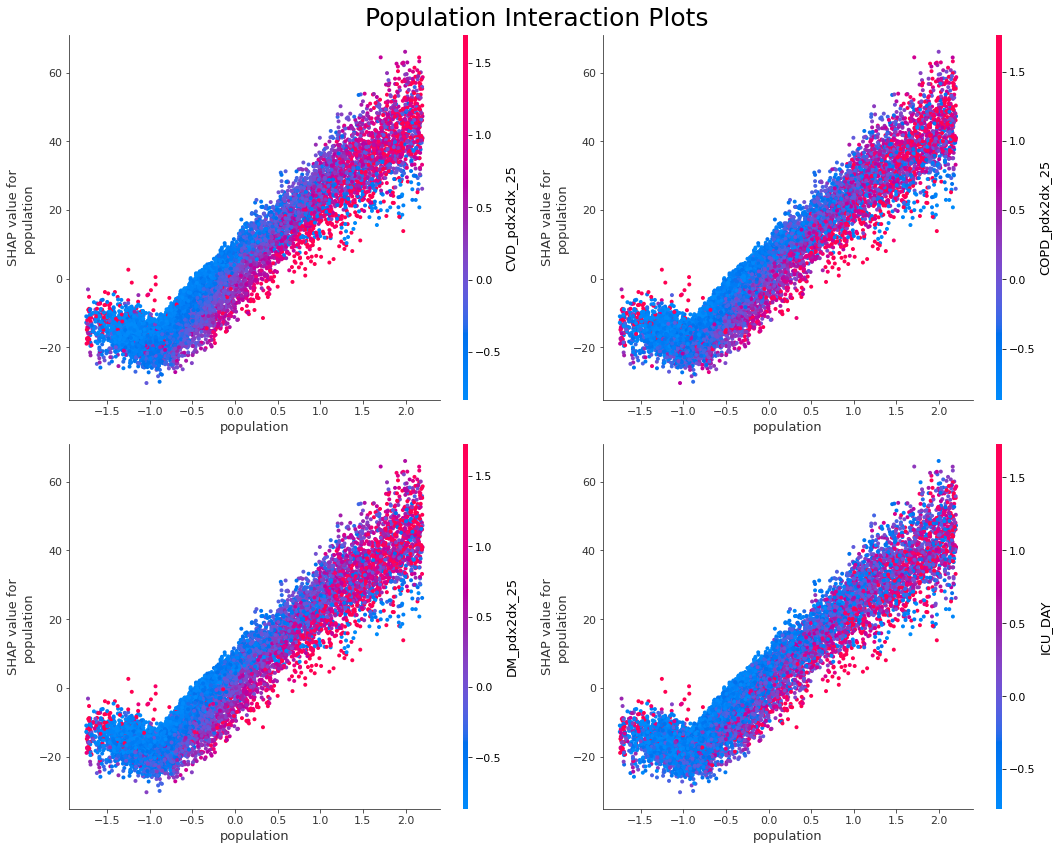

In [41]:
ys = ['CVD_pdx2dx_25','COPD_pdx2dx_25','DM_pdx2dx_25','ICU_DAY']
f, axes = plt.subplots(2,2, figsize=(15, 12))
axes = axes.ravel()

inds = shap.approximate_interactions("population", shap_values_test_lower, X_test_standardized_lower)

# make plots colored by each of the top three possible interacting features
for j in range(4):
    for i in range(len(X_test_standardized_lower.columns)):
        if X_test_standardized_lower.columns[inds[i]] == ys[j]:       
            shap.dependence_plot("population", shap_values_test_lower, X_test_standardized_lower, 
                                 interaction_index=inds[i], ax=axes[j], show=False)   
plt.suptitle('Population Interaction Plots', fontsize=25)
plt.tight_layout()
plt.show()

In [10]:
from sklearn.inspection import permutation_importance

gbr_feature_importance = gbr_model.feature_importances_
sorted_idx = np.argsort(gbr_feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(30, 10))
plt.subplot(1, 2, 1)
plt.barh(pos, gbr_feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

# gbr_result = permutation_importance(gbr_model, X_test_standardized, y_test, n_repeats=10,
#                                 random_state=42, n_jobs=2)
# sorted_idx2 = result.importances_mean.argsort()
# plt.subplot(1, 2, 2)
# plt.boxplot(gbr_result.importances[sorted_idx2].T,
#             vert=False, labels=np.array(X_train_standardized.columns)[sorted_idx2])
# plt.title("Permutation Importance (test set)")
# fig.tight_layout()
# plt.show()

# Appendix
- Adaboost

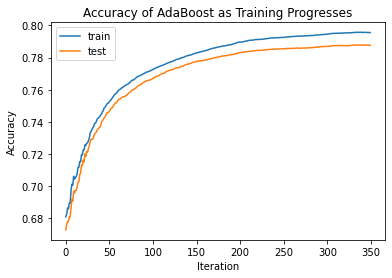

In [16]:
fitted_ada = AdaBoostRegressor(
    base_estimator=DecisionTreeRegressor(max_depth=5),
    n_estimators=350,
    learning_rate=0.05).fit(X_train_standardized, y_train)

train_scores = list(fitted_ada.staged_score(X_train_standardized, y_train))
test_scores = list(fitted_ada.staged_score(X_test_standardized, y_test))

plt.plot(train_scores,label='train')
plt.plot(test_scores,label='test')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title("Accuracy of AdaBoost as Training Progresses")
plt.legend()

max(train_scores), max(test_scores)

f, ax = plt.subplots(1, figsize=(8,5))
ax.plot(train_scores,label='train')
ax.plot(test_scores,label='test')
ax.set_xlabel('Iteration')
ax.set_ylabel('Accuracy')
ax.set_title("AdaBoost Accuracy")
plt.legend()
plt.show()
f.savefig('adaboost_results.png')

In [203]:
labels=['CVD','Diabetic','Stroke','Parkinson','COPD','ICU Days (#)', 'popdensity',
       'North American native (%)','Alzheimer','Age', 'Dementia', 'Summer PM2.5',
       'Summer Temperature','Winter Temperature','Malignant Neoplasms: Unspecified',
        'Asian (%)', 'Malignant Neoplasm:Lymphatic Tissue','Malignant Neoplasm: Genitourinary',
       'Female (%)','Black(%)']

labels = ['Female (%)','Age',
       'Poverty (%)', 'Population Density', 'Median House Value', 
       'Med Household Income', 'Owner Occpancy (%)',  'Education (%)',
       'Smoke Rate', 'Mean Bmi', 'White(%)', 'Black(%)',
       'Other Race (%)', 'Asian (%)', 'Hispanic (%)', 'North American Native (%)',
         'ICU Days', 'CCI Day', 'LOS',
       'Parkinson', 'Alzheimer', 'Dementia',
       'COPD', 'Diabetic',
       'Stroke', 'CVD', 'Malignant Neoplasm: Oral',
       'Malignant Neoplasm: Digetive', 'Malignant Neoplasm:Respiratory',
        'Malignant Neoplasm:Bone', 'Malignant Neoplasm:Genitourinary',
       'Malignant Neoplasm:Unspecified', 'Malignant Neoplasm:Lymphatic', 'Bengign Neoplasm', 'Carcinoma in Situ',
       'Neoplasm: Uncertain Behavior', 'Neoplasm: Unspecified Nature', 
        'Summer PM2.5', 'Winter PM2.5',
       'Fall PM2.5', 'Spring PM2.5', 'Summer Ozone',
       'Winter Ozone', 'Fall Ozone', 'Spring Ozone',
       'Summer NO2', 'Winter NO2', 'Fall NO2',
       'Spring NO2', 'Summer Temperature', 'Summer Humidity',
       'Winter Temperature', 'Winter Humidity']